# MNIST com Numpy

Resolveremos agora o mesmo problema utilizando diferentes bibliotecas, apenas Numpy; Keras; Tensorflow e Pytorch. A ideia, aqui, é que você tenha uma experiência com cada uma delas para aí poder saber diferencias quando utilizar cada uma na melhor situação.

## O problema MNIST

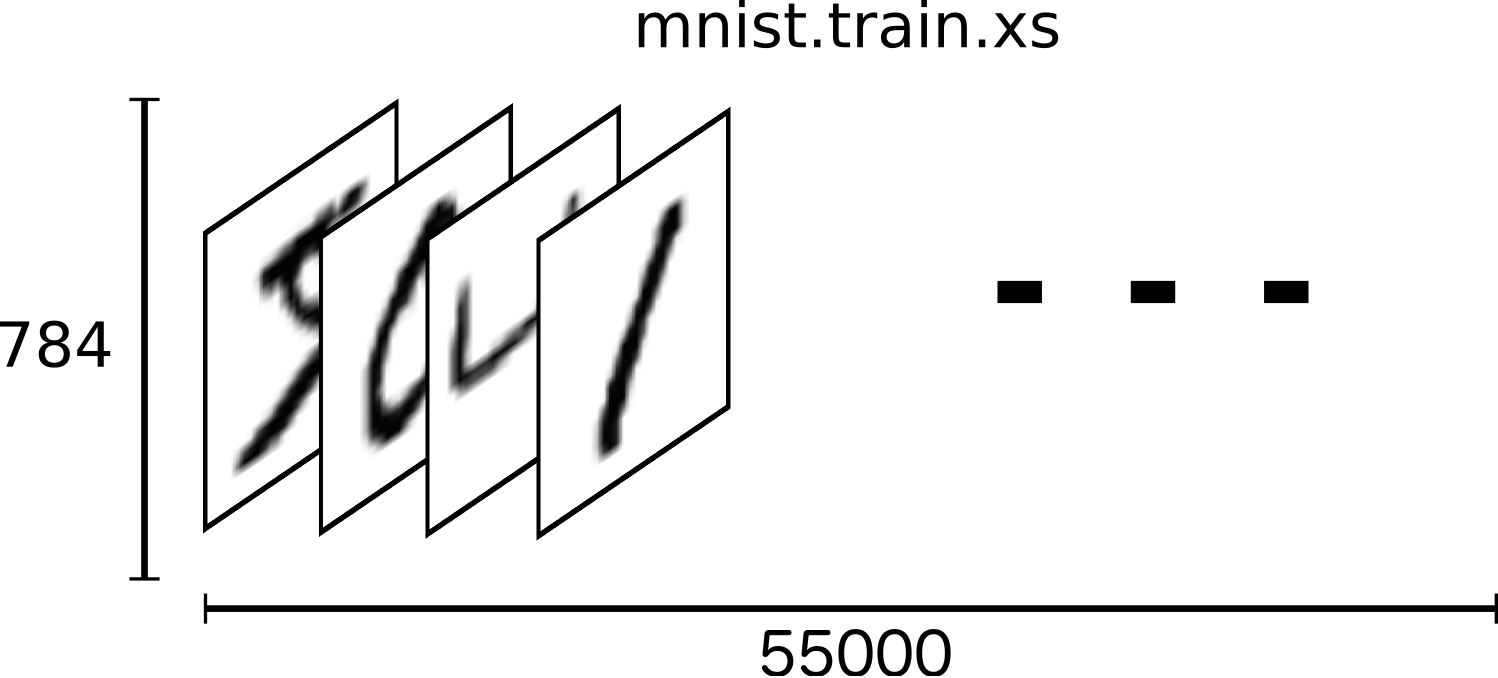

In [2]:
# import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


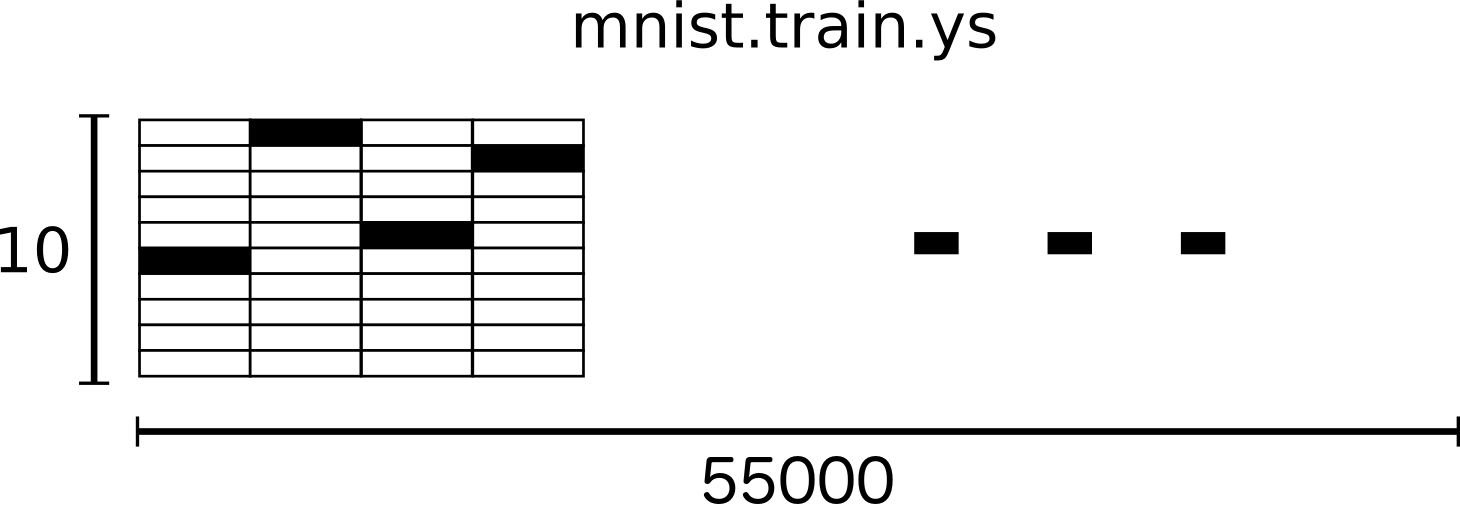

In [3]:
# check MNIST training images matrix shape
mnist.train.images.shape

(55000, 784)

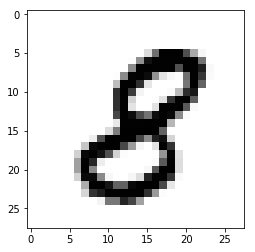

In [7]:
# check MNIST training images matrix data
sample_img = mnist.train.images[5].reshape(28, 28)
# plot the image
plt.imshow(sample_img).set_cmap('Greys')

# Construindo nossa Rede Neural


## Hiperparâmetros

In [2]:
resume = False
batch_size = 16
lr = 2e-2
reg = 1e-4
h1_size = 100 # first hidden layer
h2_size = 10 # second hidden layer
D = 28*28 # dimensionality

## Função Feedfoward

Para uma determinada entrada $x_i$ e saida $h_j$ nós temos: $h_j = x_i * W_{ij} + b_j$

### Função Linear

In [4]:
def xW_plus_b(x, W, b):
    return np.dot(x,W) + b # in some cases you can even drop the bias b

### Função Softmax

A Função Sigmoid é uma função de ativação não linear que é definida da seguinte forma: $p_k=\frac{e^{z_k}}{\sum_i e^{z_i}}$

Na prática, só precisamos entender que ela dá uma probabilidade de ser cada uma das classes

In [5]:
def softmax(x):
    maxes = np.amax(x, axis=1, keepdims=True)
    e = np.exp(x - maxes) # improves numerics
    dist = e / np.sum(e, axis=1, keepdims=True)
    return dist

### Função ReLU

Outra função de ativação, é definida por:

$z_i=relu(h_i)$ onde,

  \begin{equation}
    relu(h_i)=
    \begin{cases}
      h_1, & \text{se}\ h \geq 1 \\
      0, & \text{otherwise}
    \end{cases}
  \end{equation}

   

In [6]:
def relu(x):
    x[x<0] = 0
    return x

### Juntando tudo

In [7]:
def forward(X, model):
    # evaluate class scores, [N x K]
    hs = [] # we'll need the h's for computing gradients
    
    z1 = xW_plus_b(X, model['W1'], model['b1'])
    h1 = relu(z1); hs.append(h1)
    
    z2 = xW_plus_b(h1, model['W2'], model['b2'])
    h2 = relu(z2); hs.append(h2)
    
    probs = softmax(h2)
    return probs, hs

## Backpropagation

Aqui, temos que saber as derivadas parciais das funções de ativação.

Não vou entrar em detalhes das derivadas parciais.

Para quem tiver curiosidade, vou colocar as referências no pós aula.

In [9]:
def dsoftmax(h, y, batch_size):
    h[range(batch_size),y] -= 1
    return h/y.shape[0] # divide by batch size

In [10]:
def drelu(dz, h):
    dz[h <= 0] = 0 # backprop relu
    return dz

In [11]:
def dxW_plus_b(dh, model):
    return np.dot(dh, model['W2'].T)

### Juntando tudo

In [19]:
def backward(y, probs, hs, model):
    grads = { k : np.zeros_like(v) for k,v in model.items() }
    dh2 = dsoftmax(probs, y, batch_size)
    
    # second hidden layer
    grads['W2'] = np.dot(hs[0].T, dh2)
    grads['b2'] = np.sum(dh2, axis=0, keepdims=True)

    # first hidden layer
    dh1 = dxW_plus_b(dh2, model)
    dh1 = drelu(dh1, hs[0]) # backprop through relu
    grads['W1'] = np.dot(X.T, dh1)
    grads['b1'] = np.sum(dh1, axis=0, keepdims=True)
    return grads

## Métricas de avaliação

In [13]:
# evaluate training set accuracy
def eval_model(model):
    X = mnist.test.images
    y = mnist.test.labels
    hidden_layer = np.maximum(0, np.dot(X, model['W1']) + model['b1'])
    scores = np.dot(hidden_layer, model['W2']) + model['b2']
    predicted_class = np.argmax(scores, axis=1)
    return (np.mean(predicted_class == y))

## Inicializando o Modelo

In [17]:
model = {}
# first layer
model['W1'] = np.random.randn(D,h1_size) / np.sqrt(h1_size) 
model['b1'] = np.random.randn(1,h1_size) / np.sqrt(h1_size) 
#second layer
model['W2'] = np.random.randn(h1_size,h2_size) / np.sqrt(h2_size)
model['b2'] = np.random.randn(1,h2_size) / np.sqrt(h2_size)

In [32]:
loss_history = []
smoothing_factor = 0.95
running_loss = 0
epoch = 10000
for i in range(epoch):
    X, y = mnist.train.next_batch(batch_size)
    
    probs, hs = forward(X, model)
    
    # compute the loss: average cross-entropy loss and L2 regularization
    y_logprobs = -np.log(probs[range(batch_size),y]) # we want probs on the y labels to be large
    reg_loss = 0.5*reg*np.sum([np.sum(w*w) for w in model.values()])
    loss = np.sum(y_logprobs)/batch_size + reg_loss

    grads = backward(y, probs, hs, model) # data gradients
    grads = {k : v+reg*model[k] for (k,v) in grads.items()} # L2 gradients
    
    # update parameters
    model = {k : model[k] - lr*grads[k] for (k,v) in grads.items()}
    
    # boring book-keeping
    running_loss = smoothing_factor*running_loss + (1-smoothing_factor)*loss
    if i % 1000 == 0: print("iteration {}: test accuracy {:3f}".format(i, eval_model(model)))
    if i % 1000 == 0: print("\titeration %d: loss %f" % (i, running_loss))
    if i % 10 == 0: loss_history.append((i,running_loss))

iteration 0: test accuracy 0.971800
	iteration 0: loss 0.002854
iteration 1000: test accuracy 0.969900
	iteration 1000: loss 0.092218
iteration 2000: test accuracy 0.972100
	iteration 2000: loss 0.123394
iteration 3000: test accuracy 0.973300
	iteration 3000: loss 0.093797
iteration 4000: test accuracy 0.972500
	iteration 4000: loss 0.111782
iteration 5000: test accuracy 0.972200
	iteration 5000: loss 0.097388
iteration 6000: test accuracy 0.973300
	iteration 6000: loss 0.099129
iteration 7000: test accuracy 0.973200
	iteration 7000: loss 0.106762
iteration 8000: test accuracy 0.973100
	iteration 8000: loss 0.101290
iteration 9000: test accuracy 0.972900
	iteration 9000: loss 0.096375


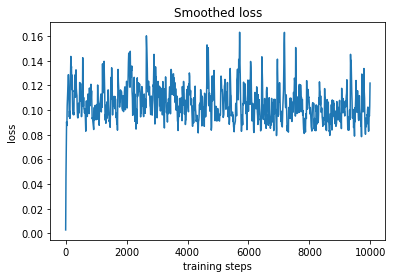

In [33]:
plt.title("Smoothed loss")
plt.xlabel("training steps")
plt.ylabel("loss")

train_steps, smoothed_losses = zip(*loss_history)
plt.plot(train_steps, smoothed_losses)
plt.show()

## Alguns Exemplos

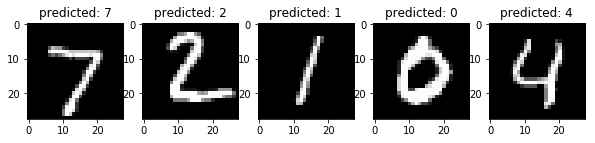

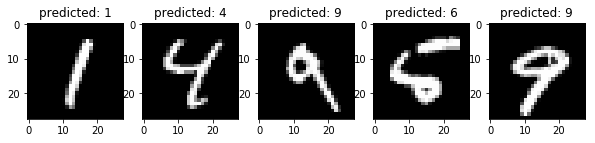

In [34]:
import matplotlib.cm as cm


X = mnist.test.images
y = mnist.test.labels
hidden_layer = np.maximum(0, np.dot(X, model['W1']) + model['b1'])
scores = np.dot(hidden_layer, model['W2']) + model['b2']
predicted_class = np.argmax(scores, axis=1)

for i in range(0,10,5):
    img1 = np.reshape(X[i+0,:], (28,28))
    img2 = np.reshape(X[i+1,:], (28,28))
    img3 = np.reshape(X[i+2,:], (28,28))
    img4 = np.reshape(X[i+3,:], (28,28))
    img5 = np.reshape(X[i+4,:], (28,28))
    plt.figure(i, figsize=(10,4))
    plt.subplot(151) ; plt.title("predicted: " + str(predicted_class[i]))
    plt.imshow(img1, cmap=cm.gray)
    plt.subplot(152) ; plt.title("predicted: " + str(predicted_class[i+1]))
    plt.imshow(img2, cmap=cm.gray)
    plt.subplot(153) ; plt.title("predicted: " + str(predicted_class[i+2]))
    plt.imshow(img3, cmap=cm.gray)
    plt.subplot(154) ; plt.title("predicted: " + str(predicted_class[i+3]))
    plt.imshow(img4, cmap=cm.gray)
    plt.subplot(155) ; plt.title("predicted: " + str(predicted_class[i+4]))
    plt.imshow(img5, cmap=cm.gray)